# Freeform Optimization

In [1]:
import numpy as np

from optiland import optic, optimization

Define a starting lens:

We define a singlet lens, which has a freeform as its first surface.

The freeform surface is defined as:

$z(x, y) = \frac{r^2}{R \cdot (1 + \sqrt{(1 - (1 + k) \cdot r^2 / R^2)})} + \sum\limits_{i}\sum\limits_{j}{C_{i, j} \cdot x^i \cdot y^j}$

where $x$ and $y$ are the local surface coordinates, $r^2 = x^2 + y^2$, $R$ is the radius of curvature, $k$ is the conic constant and $C_{i, j}$ is the polynomial coefficient for indices $i, j$.

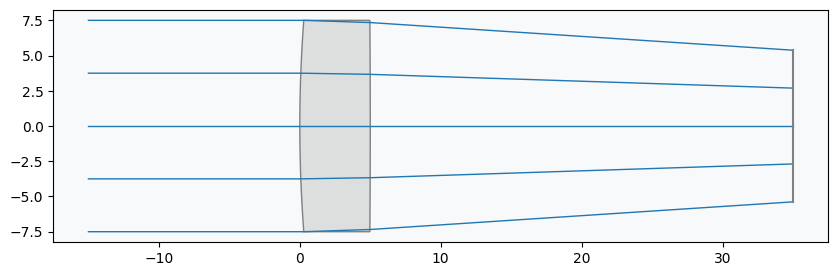

In [ ]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, thickness=np.inf)
lens.add_surface(
    index=1,
    radius=100,
    thickness=5,
    surface_type="polynomial",
    is_stop=True,
    material="SF11",
    coefficients=[],
)
lens.add_surface(index=2, thickness=30, radius=-1000)
lens.add_surface(index=3)

# set aperture
lens.set_aperture(aperture_type="EPD", value=15)

# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)

# add wavelength
lens.add_wavelength(value=0.55, is_primary=True)

# draw lens
lens.draw(num_rays=5)

Define optimization problem:

In [3]:
problem = optimization.OptimizationProblem()

Add operands (targets for optimization). We will minimize the RMS spot size on-axis and force the on-axis field chief ray to intersect the image plane at y = 3 mm.

In [ ]:
# RMS spot size operand
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "wavelength": 0.55,
    "num_rays": 5,
}
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=1,
    input_data=input_data,
)

# Real y-intercept operand
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "Px": 0,
    "Py": 0,
    "wavelength": 0.55,
}
problem.add_operand(
    operand_type="real_y_intercept",
    target=3,
    weight=1,  # <-- target=3
    input_data=input_data,
)

Define variables - let the first 9 coefficients of the polynomial coefficients vary.

In [ ]:
for i in range(3):
    for j in range(3):
        problem.add_variable(
            lens,
            "polynomial_coeff",
            surface_number=1,
            coeff_index=(i, j),
        )

Check initial merit function value and system properties:

In [6]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                26.1803 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════╤══════════╤══════════╤═════════╤══════════╤════════════════════╕
│    │ Operand Type     │   Target │   Weight │   Value │    Delta │   Contribution (%) │
╞════╪══════════════════╪══════════╪══════════╪═════════╪══════════╪════════════════════╡
│  0 │ rms spot size    │        0 │        1 │ 4.14491 │  4.14491 │             65.623 │
│  1 │ real y intercept │        3 │        1 │ 0       │ -3       │             34.377 │
╘════╧══════════════════╧══════════╧══════════╧═════════╧══════════╧════════════════════╛
╒════╤══════════════════╤═══════════╤═════════╤══════════════╤══════════════╕
│    │ Variable Type    │   Surface │   Value │ Min. Bound   │ Max. Bound   │
╞════╪══════════════════╪═══════════╪═══════

Define optimizer:

In [7]:
optimizer = optimization.OptimizerGeneric(problem)

Run optimization:

In [8]:
optimizer.optimize(tol=1e-9)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0007136726720011206
        x: [-4.565e-06 -1.158e-01  1.400e-02 -7.709e-09  1.591e-07
            -7.314e-09  1.394e-02 -1.418e-05  9.539e-07]
      nit: 16
      jac: [-5.123e-06  1.932e-04 -6.649e-04  9.056e-06  7.249e-03
            -2.941e-03 -1.224e-04  1.634e-03  1.562e-04]
     nfev: 370
     njev: 37
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

Print merit function value and system properties after optimization:

In [9]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │            0.000713673 │           99.9973 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════╤══════════╤══════════╤══════════╤══════════════╤════════════════════╕
│    │ Operand Type     │   Target │   Weight │    Value │        Delta │   Contribution (%) │
╞════╪══════════════════╪══════════╪══════════╪══════════╪══════════════╪════════════════════╡
│  0 │ rms spot size    │        0 │        1 │ 0.026714 │  0.026714    │        99.9949     │
│  1 │ real y intercept │        3 │        1 │ 2.99981  │ -0.000190397 │         0.00507948 │
╘════╧══════════════════╧══════════╧══════════╧══════════╧══════════════╧════════════════════╛
╒════╤══════════════════╤═══════════╤══════════════╤══════════════╤══════════════╕
│    │ Variable Type    │   Surface │        Value │ Min. Bound   │ Max. Bound   │
╞═══

Draw final lens:

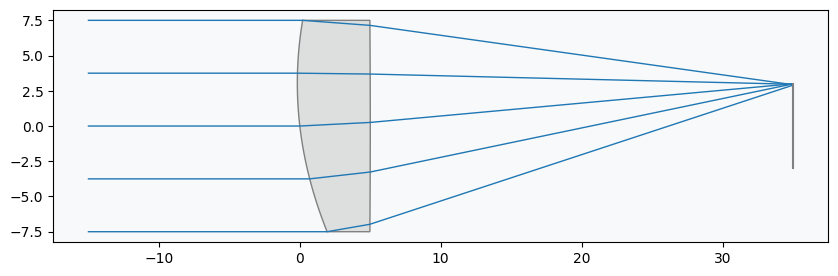

In [10]:
lens.draw(num_rays=5)